In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos, numbered_symbols, Abs
import numpy as np
import rebound
from scipy.integrate import odeint
from sympy import init_printing
init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [2]:
m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = symbols("m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2")
f27, f31, m = symbols("f27, f31, m")

In [3]:
import math
import numpy as np

def LaplaceCoefficient(s,j,a,n):
    j = abs(j)
    outside = 1
    for k in range(j):
        outside *= s+k
    outside *= 2./math.factorial(j)*a**(j-n)
    cterm = 1.
    cbterm = 1.
    for k in range(n):
        cbterm *= (j-k)
    csum = cbterm
    i=1
    while cbterm > np.finfo(float).eps or cbterm == 0:
        cterm = cterm*(s+i-1)*(s+j+i-1)/i/(j+i)*a**2
        cbterm = cterm
        for k in range(n):
            cbterm *= j+2*i-k
        csum += cbterm
        i+=1
    return outside*csum

In [4]:
Tf27 = f27*sqrt(2*Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1)
Tf31 = f31*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2)
H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
H = H0 - m1/M1*mu2/Lambda2**2*(Tf27 + Tf31)

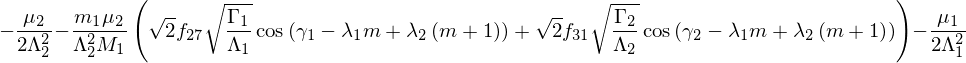

In [5]:
H

# Calculate Hamilton's equations symbolically

In [6]:
var = (m1, M1, mu1, mu2, m, f27, f31, lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2)
params = (m1, M1, mu1, mu2, m, f27, f31)

In [7]:
lambda1dot = lambdify(var, diff(H, Lambda1), 'numpy')
lambda2dot = lambdify(var, diff(H, Lambda2), 'numpy')
Lambda1dot = lambdify(var, -diff(H, lambda1), 'numpy')
Lambda2dot = lambdify(var, -diff(H, lambda2), 'numpy')
gamma1dot = lambdify(var, diff(H, Gamma1), 'numpy')
gamma2dot = lambdify(var, diff(H, Gamma2), 'numpy')
Gamma1dot = lambdify(var, -diff(H, gamma1), 'numpy')
Gamma2dot = lambdify(var, -diff(H, gamma2), 'numpy')

In [8]:
def diffeq(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dot(*var), lambda2dot(*var), Lambda1dot(*var), Lambda2dot(*var), gamma1dot(*var), gamma2dot(*var), Gamma1dot(*var), Gamma2dot(*var)]
    return dydt

# Convenience functions for REBOUND Nbody integration

In [9]:
def mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return Mint*self.m/(Mint+self.m)

def Mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return (Mint+self.m)/Mint*self._sim.contents.particles[0].m

def Lambda(self):
    return self.mjac*np.sqrt(self._sim.contents.G*self.Mjac*self.a)

def Gamma(self):
    return self.Lambda*(1.-np.sqrt(1.-self.e**2))

def gamma(self):
    return -self.pomega

def J(self):
    if self.hash == 1:
        return self.Lambda + m*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    if self.hash == 2:
        return self.Lambda - (m+1)*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    
def mu(self):
    return self._sim.contents.G**2*self.Mjac**2*self.mjac**3

def phi(self):
    return (m0+1)*self._sim.contents.particles[2].l - m0*self._sim.contents.particles[1].l - self.pomega

rebound.Particle.mjac = property(mjac)
rebound.Particle.Mjac = property(Mjac)
rebound.Particle.Lambda = property(Lambda)
rebound.Particle.J = property(J)
rebound.Particle.mu = property(mu)
rebound.Particle.phi = property(phi)
rebound.Particle.Gamma = property(Gamma)
rebound.Particle.gamma = property(gamma)

def wrap(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

# This function does an N-body integration and a numerical integration of Hamilton's equations we derived symbolically above

In [28]:
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 1000 # number of inner planet orbits to integrate for
Nout = 10000 # number of output points

m0=7 #m+1:m resonance
alpha = (m0/(m0+1))**(2/3)
f270 = 1/2*(-2*(m0+1)*LaplaceCoefficient(0.5, m0+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m0+1, alpha, 1))
f310 = 1/2*((2*m0+1)*LaplaceCoefficient(0.5, m0, alpha, 0) + alpha*LaplaceCoefficient(0.5, m0, alpha, 1))

logmass = -5.1
delta = (1-alpha)/alpha*(2/3*10**logmass)**(-1/3)
print(10**logmass)
print(delta)

deltalambda = np.pi
sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m0+1)/m0, l=deltalambda)
sim.move_to_com()
ps = sim.particles

# Calculate correction to averaged variables for hamiltonian integration
deltan = 2*np.pi/ps[1].P-2*np.pi/ps[2].P
prefac = ps[2].mu/ps[2].Lambda**2*ps[1].m/ps[0].m/deltan
def transform(deltalambda, prefac):
    s=0
    for j in range(1,150):
        s += LaplaceCoefficient(0.5, j, alpha, 0)*np.cos(j*deltalambda)
    s -= alpha*np.cos(deltalambda)
    s = s*prefac
    return s
nptransform = np.vectorize(transform)
s = transform(deltalambda, prefac)
print(s)

mu10 = ps[1].mu
mu20 = ps[2].mu
y0 = (ps[1].l, ps[2].l, ps[1].Lambda, ps[2].Lambda, ps[1].gamma, ps[2].gamma, ps[1].Gamma, ps[2].Gamma)
y0offset = (ps[1].l, ps[2].l, ps[1].Lambda-s, ps[2].Lambda+s, ps[1].gamma, ps[2].gamma, ps[1].Gamma, ps[2].Gamma)
params0 = (ps[1].m, ps[0].m, ps[1].mu, ps[2].mu, m0, f270, f310)
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)

Nlambda1, Nlambda2, NLambda1, NLambda2, Ngamma1, Ngamma2, NGamma1, NGamma2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Nphi1, Nphi2, Nh1, Nk1, Nh2, Nk2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
NPsi, Npsi, Nx, Ny = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    orbits = sim.calculate_orbits(heliocentric=True)
    sim.integrate(time)
    Nlambda1[i] = orbits[0].l
    Nlambda2[i] = orbits[1].l
    NLambda1[i] = ps[1].m*np.sqrt(sim.G*ps[0].m*orbits[0].a)
    NLambda2[i] = ps[2].m*np.sqrt(sim.G*ps[0].m*orbits[1].a)
    Ngamma1[i] = -orbits[0].pomega
    Ngamma2[i] = -orbits[1].pomega
    NGamma1[i] = NLambda1[i]*(1.-np.sqrt(1.-orbits[0].e**2))
    NGamma2[i] = NLambda2[i]*(1.-np.sqrt(1.-orbits[1].e**2))
    Nphi1[i] = ps[1].phi
    Nphi2[i] = ps[2].phi
    Nh1[i] = ps[1].e*np.cos(Nphi1[i])
    Nk1[i] = ps[1].e*np.sin(Nphi1[i])
    Nh2[i] = ps[2].e*np.cos(Nphi2[i])
    Nk2[i] = ps[2].e*np.sin(Nphi2[i])
    NPsi[i] = NGamma1[i] + NGamma2[i]
    Nx[i] = NPsi[i]*np.cos(Nphi1[i])
    Ny[i] = NPsi[i]*np.sin(Nphi1[i])

Nlambda1=npwrap(Nlambda1)
Nlambda2=npwrap(Nlambda2)
Ngamma1=npwrap(Ngamma1)
Ngamma2=npwrap(Ngamma2)
Nphi1 = npwrap(Nphi1)
Nphi2 = npwrap(Nphi2)
Npsi = npwrap(Npsi)

sol = odeint(diffeq, y0offset, times, args=params0)
Hlambda1 = npwrap(sol[:,0])
Hlambda2 = npwrap(sol[:,1])
HLambda1 = sol[:,2]
HLambda2 = sol[:,3]
Hgamma1 = npwrap(sol[:,4])
Hgamma2 = npwrap(sol[:,5])
HGamma1 = sol[:,6]
HGamma2 = sol[:,7]
Hphi1 = npwrap((m0+1)*Hlambda2 - m0*Hlambda1 + Hgamma1)
Hphi2 = npwrap((m0+1)*Hlambda2 - m0*Hlambda1 + Hgamma2)
Hh1 = np.sqrt(2.*HGamma1/HLambda1)*np.cos(Hphi1)
Hk1 = np.sqrt(2.*HGamma1/HLambda1)*np.sin(Hphi1)
Hh2 = np.sqrt(2.*HGamma2/HLambda2)*np.cos(Hphi2)
Hk2 = np.sqrt(2.*HGamma2/HLambda2)*np.sin(Hphi2)
HPsi = HGamma1 + HGamma2
Hx = HPsi*np.cos(Hphi1)
Hy = HPsi*np.sin(Hphi1)

7.943282347242822e-06
5.341500186327213
-1.71997028286e-10


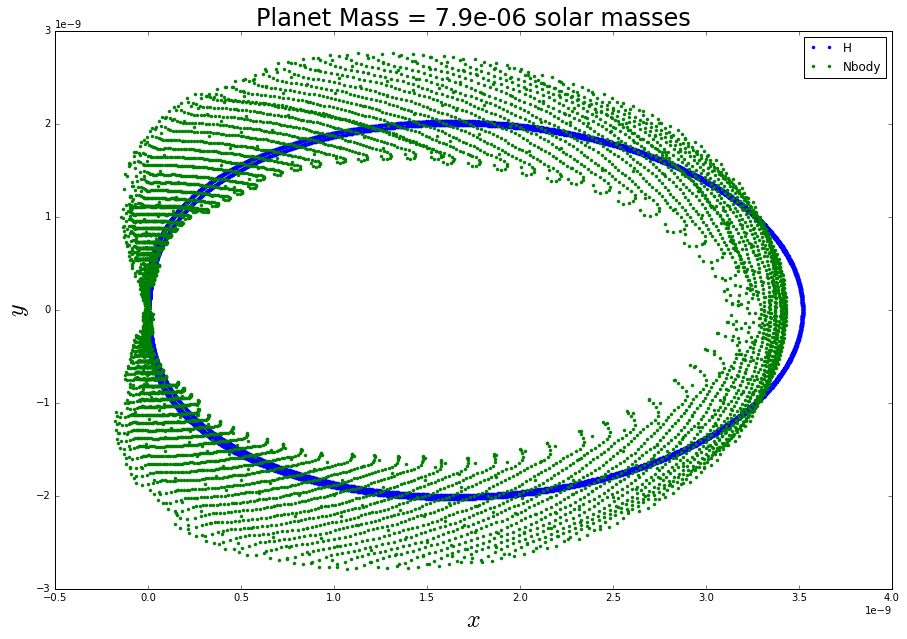

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("$x$", fontsize=24)
ax.set_ylabel(r"$y$", fontsize=24)

ax.plot(Hx, Hy, '.', label='H')
ax.plot(Nx, Ny, '.', label='Nbody')

ax.legend()

# Canonical Transformation to 2 degrees of freedom

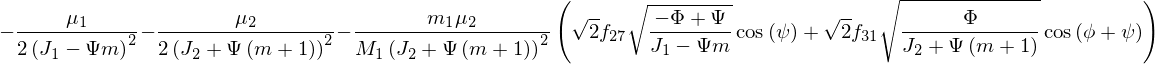

In [12]:
J1, J2, Psi, psi, Phi, phi = symbols("J1, J2, Psi, psi, Phi, phi")
H2 = H
H2 = H2.subs(Lambda1, J1 - m*Psi)
H2 = H2.subs(Lambda2, J2 + (m+1)*Psi)
H2 = H2.subs(Gamma1, Psi - Phi)
H2 = H2.subs(Gamma2, Phi)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + gamma1, psi)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + gamma2, psi+phi)
H2

In [13]:
var = (m1, M1, mu1, mu2, m, f27, f31, J1, J2, Psi, psi, Phi, phi)
params = (m1, M1, mu1, mu2, m, f27, f31, J1, J2)
Psidot = lambdify(var, -diff(H2, psi), 'numpy')
psidot = lambdify(var, diff(H2, Psi), 'numpy')
Phidot = lambdify(var, -diff(H2, phi), 'numpy')
phidot = lambdify(var, diff(H2, Phi), 'numpy')
def diffeq2(y, t, *params):
    Psi, psi, Phi, phi = y
    var = np.concatenate((params,y))
    dydt = [Psidot(*var), psidot(*var), Phidot(*var), phidot(*var)]
    return dydt

In [14]:
Psiinit = y0[-1] + y0[-2] # Gamma1 + Gamma2
psiinit = (m0+1)*y0[1] - m0*y0[0] + y0[4]
Phiinit = y0[-1]
phiinit = y0[5]-y0[4]

J1 = y0offset[2] + m0*Psiinit
J2 = y0offset[3] - (m0+1)*Psiinit

y02 = (Psiinit, psiinit, Phiinit, phiinit)
params02 = params0 + (J1, J2)

In [15]:
sol2 = odeint(diffeq2, y02, times, args=params02)
HPsi2 = sol2[:,0]
Hpsi2 = npwrap(sol2[:,1])
HPhi2 = sol2[:,2]
Hphi2 = npwrap(sol2[:,3])
Hx2 = HPsi2*np.cos(Hpsi2)
Hy2 = HPsi2*np.sin(Hpsi2)

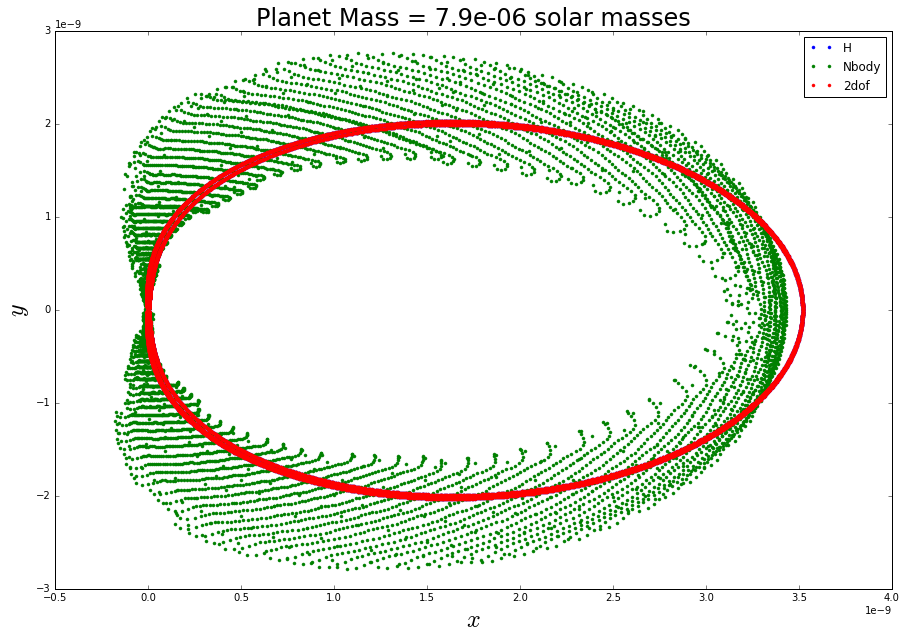

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("$x$", fontsize=24)
ax.set_ylabel(r"$y$", fontsize=24)

ax.plot(Hx, Hy, '.', label='H')
ax.plot(Nx, Ny, '.', label='Nbody')
ax.plot(Hx2, Hy2, '.', label='2dof')

ax.legend()

# 2 dof Hamiltonian

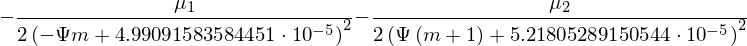

In [29]:
HKep = H0
HKep = HKep.subs(Lambda1, J1 - m*Psi)
HKep = HKep.subs(Lambda2, J2 + (m+1)*Psi)
HKep

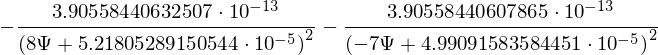

In [30]:
HKep = HKep.subs(mu1, mu10).subs(mu2, mu20).subs(m, m0)

In [32]:
Psi0init

In [ ]:
Psival = 
HKep.subs(Psi)

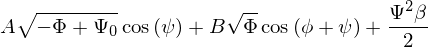

In [17]:
beta, A, B, Psi0 = symbols("beta, A, B, Psi0")
H2exp = beta/2*Psi**2 + A*sqrt(Psi0 - Phi)*cos(psi) + B*sqrt(Phi)*cos(psi + phi)
H2exp

In [19]:
var = (A, B, Psi0, beta, Psi, psi, Phi, phi)
params = (A, B, Psi0, beta)

Psidotexp = lambdify(var, -diff(H2exp, psi).subs(sqrt(-Phi + Psi0), sqrt(Abs(-Phi + Psi0))).subs(sqrt(Phi), sqrt(Abs(Phi))), 'numpy')
psidotexp = lambdify(var, diff(H2exp, Psi).subs(sqrt(-Phi + Psi0), sqrt(Abs(-Phi + Psi0))).subs(sqrt(Phi), sqrt(Abs(Phi))), 'numpy')
Phidotexp = lambdify(var, -diff(H2exp, phi).subs(sqrt(-Phi + Psi0), sqrt(Abs(-Phi + Psi0))).subs(sqrt(Phi), sqrt(Abs(Phi))), 'numpy')
phidotexp = lambdify(var, diff(H2exp, Phi).subs(sqrt(-Phi + Psi0), sqrt(Abs(-Phi + Psi0))).subs(sqrt(Phi), sqrt(Abs(Phi))), 'numpy')
def diffeq2exp(y, t, *params):
    Psi, psi, Phi, phi = y
    var = np.concatenate((params,y))
    dydt = [Psidotexp(*var), psidotexp(*var), Phidotexp(*var), phidotexp(*var)]
    return dydt

In [20]:
zeta = (ps[1].m/ps[2].m)**(1./3.)
Psi0init = (alpha - m0/(m0+1)*zeta*J2/J1)/(m0*(zeta + alpha))*J1
betainit = -3*m0**2/(zeta*alpha)*ps[2].mu/J1**4*(alpha + zeta)**5/(1+m0/(m0+1)*J2/J1)**4
C = -ps[1].m/ps[0].m*ps[2].mu/(J2 + (m0+1)*Psi0init)**2
Ainit = C*f270*np.sqrt(2./(J1-m0*Psi0init))
Binit = C*f310*np.sqrt(2./(J2+(m0+1)*Psi0init))

y02exp = y02
params02exp = (Ainit, Binit, Psi0init, betainit)

In [21]:
sol2exp = odeint(diffeq2exp, y02exp, times, args=params02exp)
HPsi2exp = sol2exp[:,0]
Hpsi2exp = npwrap(sol2exp[:,1])
HPhi2exp = sol2exp[:,2]
Hphi2exp = npwrap(sol2exp[:,3])
Hx2exp = HPsi2exp*np.cos(Hpsi2exp)
Hy2exp = HPsi2exp*np.sin(Hpsi2exp)

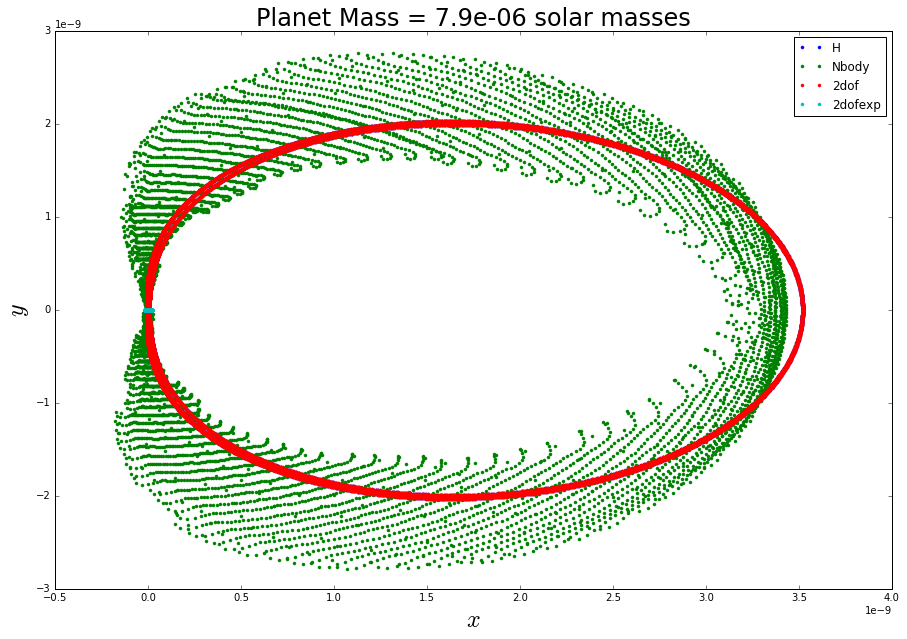

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("$x$", fontsize=24)
ax.set_ylabel(r"$y$", fontsize=24)

ax.plot(Hx, Hy, '.', label='H')
ax.plot(Nx, Ny, '.', label='Nbody')
ax.plot(Hx2, Hy2, '.', label='2dof')
ax.plot(Hx2exp, Hy2exp, '.', label='2dofexp')
ax.legend()